### Importa as bibliotecas necessárias

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PySDDP.Pen import Newave

### Lê e processa os dados do deck do Newave

In [32]:
Caminho_do_Arquivo = os.getcwd() + '/NewaveAgo2023/'

PMO = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


### Calcula a Energia Máxima Armazenada em cada reservatório equivalente

In [33]:
EAmax = np.zeros((PMO.ree.numero_rees, 12))

for i,ree_num in enumerate(PMO.confhd._ree['valor']):

    # Ignora usinas à fio d'água
    if (PMO.confhd._vol_util['valor'][i] == 0):
        continue

    for mes in range(12):

        soma_rho_equiv = PMO.confhd._ro_equiv['valor'][i][0][mes].copy()
        codigo_jusante = PMO.confhd._jusante['valor'][i]

        while (codigo_jusante != 0):
            i_jusante = PMO.confhd._codigo['valor'].index(codigo_jusante)

            if (PMO.confhd._ree['valor'][i_jusante] == ree_num):
                soma_rho_equiv += PMO.confhd._ro_equiv['valor'][i_jusante][0][mes]

            codigo_jusante = PMO.confhd._jusante['valor'][i_jusante]

        EAmax[ree_num-1][mes] += PMO.confhd._vol_util['valor'][i]*soma_rho_equiv/2.63

### Calcula a Energia Armazenada em cada reservatório equivalente

In [34]:
EA = np.zeros(PMO.ree.numero_rees)

for i,ree_num in enumerate(PMO.confhd._ree['valor']):

    # Ignora usinas à fio d'água
    if (PMO.confhd._vol_util['valor'][i] == 0):
        continue

    soma_rho_equiv = PMO.confhd._ro_equiv['valor'][i][0][0].copy()
    codigo_jusante = PMO.confhd._jusante['valor'][i]

    while (codigo_jusante != 0):
        i_jusante = PMO.confhd._codigo['valor'].index(codigo_jusante)

        if (PMO.confhd._ree['valor'][i_jusante] == ree_num):
            soma_rho_equiv += PMO.confhd._ro_equiv['valor'][i_jusante][0][0]

        codigo_jusante = PMO.confhd._jusante['valor'][i_jusante]

    EA[ree_num-1] += PMO.confhd._vol_ini['valor'][i]*PMO.confhd._vol_util['valor'][i]*soma_rho_equiv/2.63

### Calcula a Energia Controlável e a Energia à Fio D'Água em cada reservatório equivalente

In [35]:
Num_anos = np.shape(PMO.confhd._vazoes['valor'])[1]

Ectr = np.zeros((PMO.ree.numero_rees, 12, Num_anos))
Efio = np.zeros((PMO.ree.numero_rees, 12, Num_anos))

for i,ree_num in enumerate(PMO.confhd._ree['valor']):

    vazao_inc = PMO.confhd._vazoes['valor'][i].copy()

    for idx, codigo in enumerate(PMO.confhd._jusante['valor']):
        if (PMO.confhd._codigo['valor'][i] == codigo):
            vazao_inc -= PMO.confhd._vazoes['valor'][idx]

    # Usinas com reservatório
    if (PMO.confhd._vol_util['valor'][i] != 0):

        for mes in range(12):

            soma_rho_65 = PMO.confhd._ro_65['valor'][i][0][mes].copy()
            codigo_jusante = PMO.confhd._jusante['valor'][i]

            while (codigo_jusante != 0):
                i_jusante = PMO.confhd._codigo['valor'].index(codigo_jusante)

                if (PMO.confhd._ree['valor'][i_jusante] == ree_num):
                    soma_rho_65 += PMO.confhd._ro_65['valor'][i_jusante][0][mes]

                codigo_jusante = PMO.confhd._jusante['valor'][i_jusante]

            for idx, vazao_inc_ano in enumerate(vazao_inc):
                Ectr[ree_num-1][mes][idx] += vazao_inc[idx][mes]*soma_rho_65

    # Usinas à fio d'água
    else:
        for mes in range(12):

            # soma_rho_65 = PMO.confhd._ro_65['valor'][i][0][mes]
            codigo_jusante = PMO.confhd._jusante['valor'][i]

            while (codigo_jusante != 0):
                i_jusante = PMO.confhd._codigo['valor'].index(codigo_jusante)

                if (PMO.confhd._ree['valor'][i_jusante] == ree_num and PMO.confhd._vol_util['valor'][i_jusante] != 0):
                    soma_rho_65 = PMO.confhd._ro_65['valor'][i_jusante][0][mes].copy()
                    break

                codigo_jusante = PMO.confhd._jusante['valor'][i_jusante]

            for idx, vazao_inc_ano in enumerate(vazao_inc):
                Ectr[ree_num-1][mes][idx] += vazao_inc[idx][mes]*soma_rho_65


            soma_rho_65 = PMO.confhd._ro_65['valor'][i][0][mes]
            codigo_jusante = PMO.confhd._jusante['valor'][i]

            while (codigo_jusante != 0):
                i_jusante = PMO.confhd._codigo['valor'].index(codigo_jusante)

                if (PMO.confhd._ree['valor'][i_jusante] == ree_num and PMO.confhd._vol_util['valor'][i_jusante] == 0):
                    soma_rho_65 += PMO.confhd._ro_65['valor'][i_jusante][0][mes]
                    break

                codigo_jusante = PMO.confhd._jusante['valor'][i_jusante]

            for idx, vazao_inc_ano in enumerate(vazao_inc):
                Efio[ree_num-1][mes][idx] += vazao_inc[idx][mes]*soma_rho_65

### Plota a Energia Máxima Armazenada

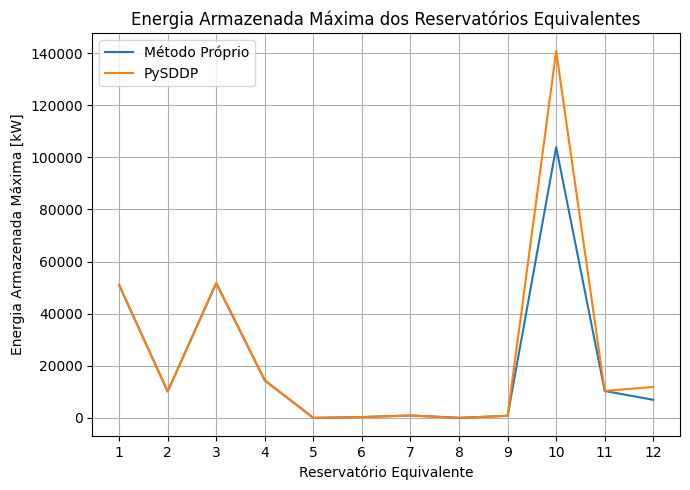

In [57]:
plt.figure(figsize=(7,5))

x = np.arange(0,12,1)

EAmax_PySDDP = [PMO.ree.ree['earmax'][PMO.ree.ree['codigo'].index(i+1)][0][0] for i in range(12)]

# for i, EAmax_ree in enumerate(EAmax):
plt.plot(x+1, EAmax[:,0], label="Método Próprio")
plt.plot(x+1, EAmax_PySDDP, label="PySDDP")

plt.title('Energia Armazenada Máxima dos Reservatórios Equivalentes')
plt.xlabel('Reservatório Equivalente')
plt.ylabel('Energia Armazenada Máxima [kW]')

plt.legend()

plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()

### Plota a Energia Controlável

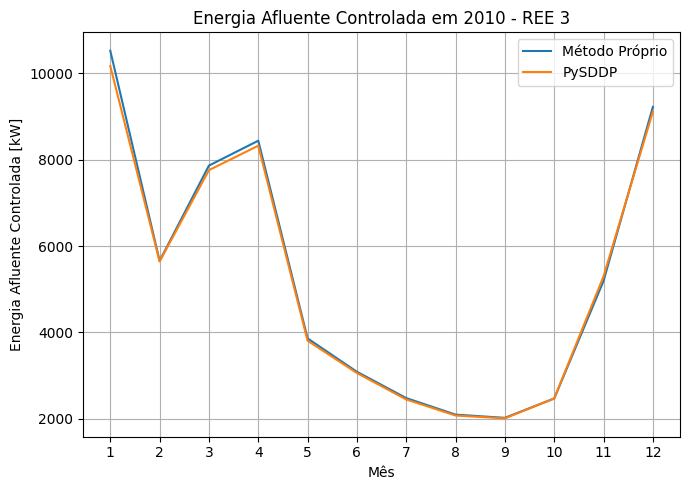

In [114]:
plt.figure(figsize=(7,5))

x = np.arange(0,12,1)

ree_target = 3
ano = 2010

plt.plot(x+1, Ectr[ree_target-1,:,ano-1931], label="Método Próprio")
plt.plot(x+1, PMO.ree.ree['ec'][PMO.ree.ree['codigo'].index(ree_target)][0,:,ano-1931], label="PySDDP")

plt.title('Energia Afluente Controlada em ' + str(ano) + " - REE " + str(ree_target))
plt.xlabel('Mês')
plt.ylabel('Energia Afluente Controlada [kW]')

plt.legend()

plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()

### Plota a Energia à Fio D'Água

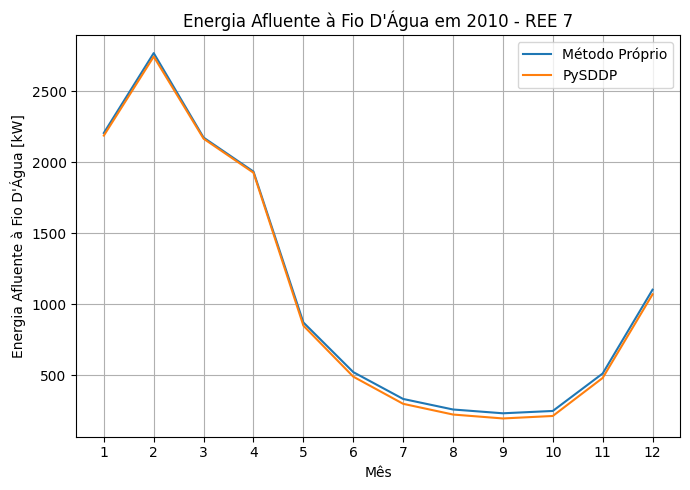

In [116]:
plt.figure(figsize=(7,5))

x = np.arange(0,12,1)

ree_target = 7
ano = 2010

plt.plot(x+1, Efio[ree_target-1,:,ano-1931], label="Método Próprio")
plt.plot(x+1, PMO.ree.ree['efio_bruta'][PMO.ree.ree['codigo'].index(ree_target)][0,:,ano-1931], label="PySDDP")

plt.title('Energia Afluente à Fio D\'Água em ' + str(ano) + " - REE " + str(ree_target))
plt.xlabel('Mês')
plt.ylabel('Energia Afluente à Fio D\'Água [kW]')

plt.legend()

plt.xticks(x+1)
plt.grid()
plt.tight_layout()
plt.show()